In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
import gensim
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
from collections import Counter
import statsmodels.api as sm

In [4]:
def calculatevec(l):
    v = np.zeros(300)
    counter = 0
    for word in l:
        if word not in stops.union("k"):
            try:
                vec = model.word_vec(word)
                v += vec
                counter +=1
            except:
                pass
    if counter == 0:
        return v
    else:
        return v/counter
def cleaning(rawtext):
    cleaned = re.sub("[^a-zA-Z]"," ", rawtext.lower())
    words = cleaned.split()
    return words
def series_to_vec(series):
    s = list(series.map(cleaning))
    n_pos = series.shape[0]
    L1 = np.array(calculatevec(s[0])).reshape(1,300)
    for i in range(1,n_pos):
        L2 = np.array(calculatevec(s[i])).reshape(1,300)
        L1 = np.concatenate((L1,L2))
    return L1
#L1 เป็น vector ของคำทั้งหมด

def cluster_kmeans(vector, nclus):
    kmeans = KMeans(n_clusters=nclus, random_state=0).fit(vector)
    kmeans.labels_
    k = pd.Series(kmeans.labels_)
    return k


def insert_k_to_df(df, series, colname):
    #df2 = df.copy()
    df.insert(loc = 0, column=str(colname), value=series)
    return df


def find_centroid(series, L1, k_num):
    group = series.values 
    #dec_g.k_pos.values
    no_pos = series.shape[0]
    centroid = np.zeros((k_num,300))
    njob = np.zeros((k_num,1))
    centroid = np.zeros((k_num,300))
    njob = np.zeros((k_num,1))
    for i in range(0,len(group)):
        njob[group[i]] += 1
        centroid[group[i]] = centroid[group[i]]+L1[i]
    for i in range(0,k_num):
        centroid[i] = centroid[i]/njob[i]
    return centroid

def centroid_2d(centroid):
    cen2d = TSNE(n_components=2, random_state=0).fit_transform(centroid)
    return cen2d

def plot_scatter(cen2d, title):
    x_plot, y_plot = cen2d.T
    plt.scatter(x_plot,y_plot)
    plt.title(title)
    return

def plot_clustergroup(cen2d, title, dict_commonword, dict_value, k_num):
    x_plot, y_plot = cen2d.T
    fig, ax = plt.subplots()
    scatter_x = x_plot
    scatter_y = y_plot
    clustergroup = np.arange(0,15) #[0,1,...,14]
    #most_common_list = list()
    
    #for g in np.unique(clustergroup):
        
        #i = np.where(clustergroup == g)
        #m = list_of_mostcommon[g]
    #ax.scatter(x_plot[i], y_plot[i], label=str(g)+str(m))
    
    l = list()
    for group in range(k_num):
        size = int(dict_value[group]/10)
        l.append(size)
    
    #print("type l", type(l))
    #print(l)
    
    #let s is the size of scatter point
    
    ax.scatter(x_plot, y_plot, s= l)
    
    sorted_dict = sorted(dict_commonword.keys())
    
    for group in range(len(sorted_dict)):
        g = str(group)
        w = dict_commonword[group]
        txt = str(g) + " " + str(w)
        ax.annotate(txt, (x_plot[group], y_plot[group]))
    
    #for k, txt in enumerate(list_of_mostcommon):
    #    ax.annotate(txt, (x_plot[k], y_plot[k]))
        
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.legend()
    plt.suptitle(title)
    return

def find_most_common_pos_list(df, k_num):
    d = dict()
    
    for g in range(k_num):
        wcdf = df[df.k_pos == g]
        s = list(wcdf.pos_en.map(cleaning))
        flatlist = [item for sublist in s for item in sublist]
        c = [w for w in flatlist if not w in stops]
        most_com = most_common(c)
        d[g] = most_com

    return d

def find_most_common_jd_list(df, k_num):
    d = dict()
    
    for g in range(k_num):
        wcdf = df[df.k_jd == g]
        s = list(wcdf.jd_en.map(cleaning))
        flatlist = [item for sublist in s for item in sublist]
        c = [w for w in flatlist if not w in stops]
        most_com = most_common(c)
        d[g] = most_com

    return d

def most_common(lst):
    return max(set(lst), key=lst.count)

#####################3
def common_word(df, series):
    if(0 == 1):
        print("Most common word")
        for g in range(0,15):
            wcdf = df[series == g]
            s = list(wcdf.pos_en.map(cleaning))
            flatlist = [item for sublist in s for item in sublist]
            print("Group: " + str(g) + " " + most_common(flatlist))
        return

    print("Most common word")
    for g in range(0,15):
        #wcdf = dec_g[dec_g.k15_pos == g]
        s = df[series == g].pos_en.map(cleaning)
        flatlist = [item for sublist in s for item in sublist]
        print("Group: " + str(g) + " " + most_common(flatlist))
    return


def dendrogram(centroid_vector, titlename, labeldict):
    lab = list(labeldict.values())
    Z = hierarchy.linkage(centroid_vector, "single")
    plt.figure(figsize = (15,8))
    plt.title = str(titlename)
    dn = hierarchy.dendrogram(Z, leaf_rotation=30, labels = lab)
    return


def top_k(numbers, k=2):
    """The counter.most_common([k]) method works
    in the following way:
    >>> Counter('abracadabra').most_common(3)  
    [('a', 5), ('r', 2), ('b', 2)]
    """
    c = Counter(numbers)
    most_common = [key for key, val in c.most_common(k)]

    return most_common

def find_best_k(vec):
    for n_cluster in range(2, 15):
    #print(n_cluster)
        kmeans = KMeans(n_clusters=n_cluster).fit(X)
        label = kmeans.labels_
        sil_coeff = silhouette_score(X, label, metric='euclidean')
        print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    return

def stats_k(k_series, dict_jobname):
    keys, vals = np.unique(k_series, return_counts=True)
    keys = pd.DataFrame(keys)
    vals = pd.DataFrame(vals)
    group_name = pd.DataFrame(list(dict_jobname.values()))
    stats = pd.merge(keys, group_name, left_index=True, right_index=True)
    stats = pd.merge(stats, vals,  left_index=True, right_index=True)
    stats.columns = ["group_num", "group_name", "val_count"]
    return stats


In [5]:
def main_calc(df, k_num):
    vec_jd = series_to_vec(df.jd_en)
    k_jd = cluster_kmeans(vec_jd, k_num)
    df2 = df.copy()
    df2.insert(loc = 0, column=str("k_jd"), value=k_jd)
    #print("COMMON WORDS")    
    #for g in range(0,k_num):
        #wcdf = dec_g[dec_g.k15_pos == g]
    #    s = df2[df2.k_jd == g].jd_en.map(cleaning)
    #    flatlist = [item for sublist in s for item in sublist]
    #    c = [w for w in flatlist if not w in stops]
    #    top_freq = " ".join(top_k(c, k=10))
    #    print("Group: " + str(g) + " " + str(top_freq))
    return df2, vec_jd

def main_viz(df, vector, k_num, dict_name):
    centroid_jd = find_centroid(df.k_jd, vector, k_num)
    cen2d_jd = centroid_2d(centroid_jd)
    dendrogram(centroid_jd, "str(df)", dict_name)
    stats = stats_k(df.k_jd, dict_name)
    plot_clustergroup(cen2d_jd, "str(df)", dict_name, stats.val_count, k_num)
    #plt.pie(stats.val_count, labels = stats.group_name);
    #print(centroid_jd)
    return stats, centroid_jd

def main_viz_2(df, centroid_jd, k_num, dict_name):
    cen2d_jd = centroid_2d(centroid_jd)
    dendrogram(centroid_jd, "Title", dict_name)
    stats = stats_k(df.k_jd, dict_name)
    plot_clustergroup(cen2d_jd,"Title", dict_name, stats.val_count, k_num)
    #plt.pie(stats.val_count, labels = stats.group_name);
    return stats

def main_cluster(df):
    vec = series_to_vec(df.jd_en)
    c = vec-centroid_dec[0]
    d = np.linalg.norm(c, axis=1)
    df_dist =pd.DataFrame(d)
    for i in range(1,8):
        c = vec-centroid_dec[i]
        d = np.linalg.norm(c, axis=1)
        df_dist= pd.concat([df_dist, pd.DataFrame(d)], axis = 1, ignore_index=True)
    k_cluster = pd.DataFrame(df_dist.idxmin(axis=1))
    k_cluster.columns = ["k_jd"]
    x = np.where(k_cluster == 0)[0]
    clus = np.mean(vec[x], axis=0).reshape(1,300)
    for group in range(1,8):
        x = np.where(k_cluster == group)[0]
        clus_i = np.mean(vec[x], axis=0).reshape(1,300)
        print(clus_i.shape)
        clus = np.concatenate((clus, clus_i), axis=0)
    df_calc = pd.concat([k_cluster, df],axis =1)
    return df_calc, clus, vec

In [6]:
def wc(df,list_g,dict_name):
    for g in list_g:
        wcdf = df[df.k_jd == g]
        s = list(wcdf.jd_en.map(cleaning))
        flatlist = [item for sublist in s for item in sublist]
        c = [w for w in flatlist if not w in stops]
        wc = WordCloud(font_path='THSarabunNew.ttf', # path ที่ตั้ง Font
                    background_color="white", # ตั้งค่าพืสี้นหลัง
                    regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                    width=1600, # กว้าง
                    height=900).generate(" ".join(c))
        #print("Group : " + str(g))
        #plt.title("Test")
        plt.figure(figsize=(20,10))
        plt.imshow(wc)
        plt.suptitle("Group:" + str(g) +  " "+dict_name[g])
        plt.show()
        
def topwords(df, list_g):
    for g in list_g:
            #wcdf = dec_g[dec_g.k15_pos == g]
            s = df[df.k_jd == g].jd_en.map(cleaning)
            flatlist = [item for sublist in s for item in sublist]
            c = [w for w in flatlist if not w in stops]
            top_freq = " ".join(top_k(c, k=10))
            print("Group " + str(g) + ": " + str(top_freq))

In [7]:
#model
#https://code.google.com/archive/p/word2vec/
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/sikawit/OneDrive/Chula/2018-2/Research/GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
dec_g = pd.read_csv("/Users/sikawit/OneDrive/Chula/2018-2/Research/Code_upload/g_dec2018.csv")
jan_g = pd.read_csv("/Users/sikawit/OneDrive/Chula/2018-2/Research/Code_upload/g_jan2019.csv")
feb_g = pd.read_csv("/Users/sikawit/OneDrive/Chula/2018-2/Research/Code_upload/g_feb2019.csv")
mar_g = pd.read_csv("/Users/sikawit/OneDrive/Chula/2018-2/Research/Code_upload/g_mar2019.csv")
adecco = pd.read_csv("/Users/sikawit/OneDrive/Chula/2018-2/Research/Code_upload/clustered_adecco.csv")
adecco.rename(columns={'jobdesc':'jd_en'}, inplace=True)

In [9]:
dec_g.head()

idx  \
0  0     
1  1     
2  2     
3  3     
4  4     

                                                                     pos_en  \
0  MIS Support (annual contract).                                             
1  Loan Operations (operating loan)                                           
2  Digital Acquisition (Senior Officer -Manager)                              
3  Management Associate Programme 2019                                        
4  Sale Engineer (Electrical Engineer), Base on Manufacturing, Pathum Thani   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         jd_en  
0  Supporting documentation, including documentation of the audit department to present the data and verify the accuracy of the information in the system. Including analysis for the department to prepare weekly reports. Monthly coordination with other agencies as assigned.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Check the validity of documents and credit conditions before the loan is approved, the track conditions customers must comply with the set credit limits, then check the power to approve loans that conform to the policy. Bank / BOT liaise with the loan officer / loan approval. In the event of a problem or need clarification.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2  Focus mainly on digital customer acquisition, bring more potential lead for online telesales and boost up new account booking from online channel.  Increase the customer potential leads through partnership with digital partner.  Deal with digital partners on acquisition plan, prepare agreement, prepare proposal on digital acquisition program, and prepare marketing communication.  Closely manage digital-acquisition telesales team to ensure that telesales call back customers within SLA time and telesales has knowledge to answer customer inquiry.  Work with digital team, technology, and demand team on new digital acquisition project such as online account opening project, e-KYC, e-consent, etc.                                                                         

In [10]:
dec_calc, vec_dec = main_calc(dec_g,8)

In [11]:
dict_jd_dec_8 = {0: "customers services", 1: "engineering", 2:"sales",
                3: "production", 4:"accounting and finance", 5:"language works",
                6: "office works", 7:"marketing"}
dec_calc.head()

k_jd  idx  \
0  6     0     
1  4     1     
2  7     2     
3  7     3     
4  2     4     

                                                                     pos_en  \
0  MIS Support (annual contract).                                             
1  Loan Operations (operating loan)                                           
2  Digital Acquisition (Senior Officer -Manager)                              
3  Management Associate Programme 2019                                        
4  Sale Engineer (Electrical Engineer), Base on Manufacturing, Pathum Thani   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         jd_en  
0  Supporting documentation, including documentation of the audit department to present the data and verify the accuracy of the information in the system. Including analysis for the department to prepare weekly reports. Monthly coordination with other agencies as assigned.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Check the validity of documents and credit conditions before the loan is approved, the track conditions customers must comply with the set credit limits, then check the power to approve loans that conform to the policy. Bank / BOT liaise with the loan officer / loan approval. In the event of a problem or need clarification.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2  Focus mainly on digital customer acquisition, bring more potential lead for online telesales and boost up new account booking from online channel.  Increase the customer potential leads through partnership with digital partner.  Deal with digital partners on acquisition plan, prepare agreement, prepare proposal on digital acquisition program, and prepare marketing communication.  Closely manage digital-acquisition telesales team to ensure that telesales call back customers within SLA time and telesales has knowledge to answer customer inquiry.  Work with digital team, technology, and demand team on new digital acquisition project such as online account opening project, e-KYC, e-consent, etc.                                     

In [12]:
k_num =8
for g in range(0,k_num):
        #wcdf = dec_g[dec_g.k15_pos == g]
        s = dec_calc[dec_calc.k_jd == g].jd_en.map(cleaning)
        flatlist = [item for sublist in s for item in sublist]
        c = [w for w in flatlist if not w in stops]
        top_freq = " ".join(top_k(c, k=10))
        print("Group " + str(g) + ": " + str(top_freq))

Group 0: work check customers care customer company clean assigned car service
Group 1: maintenance equipment repair electrical control systems system work installation machine
Group 2: customers sales customer company products new service product care assigned
Group 3: control production quality work system project process design management plan
Group 4: accounting tax check financial documents prepare accounts report assigned company
Group 5: japanese design thai work assigned support media thailand company english
Group 6: work assigned company management documents duties training control tasks coordinate
Group 7: sales marketing company business customer customers new team management plan


In [52]:
dict_jd_dec_8 = {0: "customers services", 1: "engineering", 2:"sales",
                3: "production", 4:"accounting and finance", 5:"language works",
                6: "office works", 7:"marketing"}

No handles with labels found to put in legend.


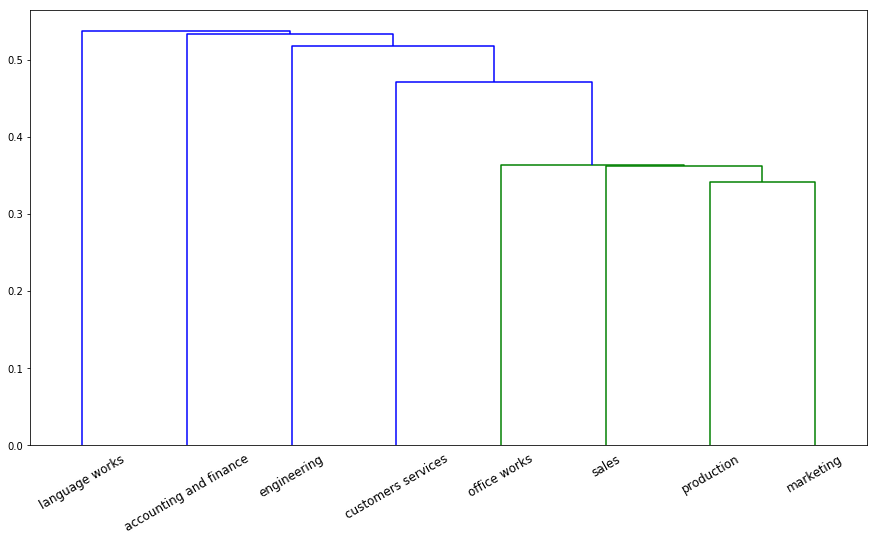

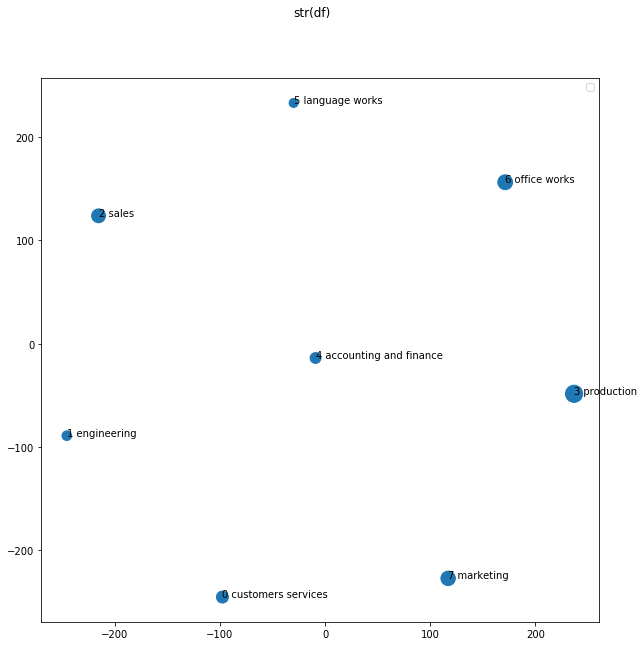

In [53]:
dec_stats, centroid_dec = main_viz(dec_calc,vec_dec,8,dict_jd_dec_8)

In [15]:
centroid_dec.shape

(8, 300)

In [20]:
jan_calc, centroid_jan, vec_jan = main_cluster(jan_g)
feb_calc, centroid_feb, vec_feb = main_cluster(feb_g)
mar_calc, centroid_mar, vec_mar = main_cluster(mar_g)

(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)


In [21]:
feb_calc.head()

k_jd  idx  \
0  7     0     
1  3     1     
2  2     2     
3  1     3     
4  7     4     

                                                                     pos_en  \
0  Sales Engineer (Telecommunications)                                        
1  project Engineer                                                           
2  Sales representative (stationary)                                          
3  Mechanical / Manufacturing / Maintenance Engineer / Electrical Engineer.   
4  Sales Manager                                                              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   jd_en  
0  Sale, offer for sale, sell and track the bidding of projects with government agencies and private enterprises, and other assignments.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1  Functional Design and Auto CAD program written by the electrical system of the estimated project cost of project control and the installation of the toll collection system. Traffic control system of coordination with customers and contractors with experience of at least 2 years on the project.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2  1. Products (stationery), according to sales targets set 2. To satisfy the needs an

In [22]:
mar_calc

k_jd    idx  \
0     2     0       
1     2     1       
2     6     2       
3     6     3       
4     2     4       
5     7     5       
6     7     6       
7     6     7       
8     4     8       
9     3     9       
10    3     10      
11    6     11      
12    3     12      
13    4     14      
14    3     15      
15    4     17      
16    7     18      
17    5     19      
18    5     20      
19    4     21      
20    5     22      
21    1     23      
22    7     25      
23    4     26      
24    3     27      
25    1     29      
26    5     30      
27    7     31      
28    7     32      
29    2     33      
...  ..     ..      
9255  1     10182   
9256  6     10183   
9257  3     10184   
9258  4     10185   
9259  6     10186   
9260  7     10187   
9261  3     10188   
9262  3     10189   
9263  0     10190   
9264  0     10192   
9265  7     10193   
9266  3     10194   
9267  3     10195   
9268  7     10196   
9269  2     10197   
9270  7     10198   
9271  7     10199   
9272  6     10200   
9273  7     10201   
9274  7     10202   
9275  4     10203   
9276  7     10204   
9277  6     10205   
9278  7     10206   
9279  0     10208   
9280  0     10214   
9281  7     10216   
9282  0     10217   
9283  1     10218   
9284  2     10219   

                                                                                               pos_en  \
0     Driver Delivery Branch protector.                                                                 
1     Inside Sales Representative / Sales Coordinator (Contract 1 Year)                                 
2     Office Administrative Specialist                                                                  
3     Quantity Surveyor ()                                                                              
4     Krungsri Ayudhya Bank Urgently Required !!! Support services (Greeter) in Bangkok.                
5     Customer Experience – Digital Banking  (AVP – VP)                                                 
6     Senior System Analyst (Chatbot or Automated Conversational)                                       
7     Customer Service Trainee (Part time) (yield 400-500 baht / day).                                  
8     Tax Specialist                                                                                    
9     QA (Software Quality Assurance) (Thai Nationality Only)                                           
10    Internal Audit (Document control procedures : ISO)                                                
11    Project Coordinator (Architecture or related field) Junior - Senior*                              
12    Architects (working at Ban Chang. Rayong) 2 Positions                                             
13    Senior Account Manager (plant sugar Northeast).                                                   
14    Engineering Projects                                                                              
15    Accountant                                                                                        
16    Administration and Coordination                                                                   
17    Frontend Developer web/mobile                                                                     
18    Frontend Developer web/mobile                                                                     
19    Accounts Receivable                                                                               
20    Purchasing (1 Position)                                                                           
21    Electrical engineers, manufacturing engineers, project engineers.                                 
22    Marketing Manager                                                                                 
23    AVP Finance & Accounting                                                                          
24    3D modeling artist                                                      

In [168]:
vec.shape

(8281, 300)

In [182]:
def main_viz_2(df, centroid_jd, k_num, dict_name):
    cen2d_jd = centroid_2d(centroid_jd)
    dendrogram(centroid_jd, "Title", dict_name)
    stats = stats_k(df.k_jd, dict_name)
    plot_clustergroup(cen2d_jd,"Title", dict_name, stats.val_count, k_num)
    #plt.pie(stats.val_count, labels = stats.group_name);
    return stats

No handles with labels found to put in legend.


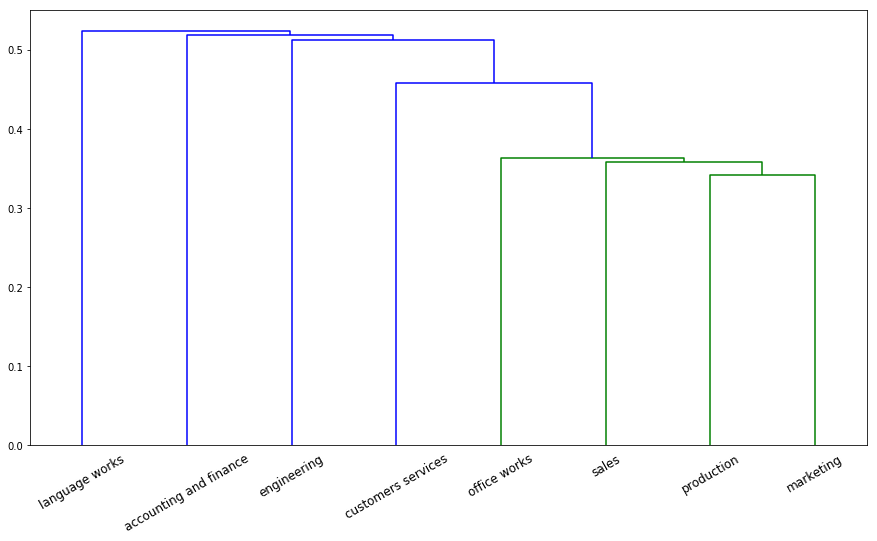

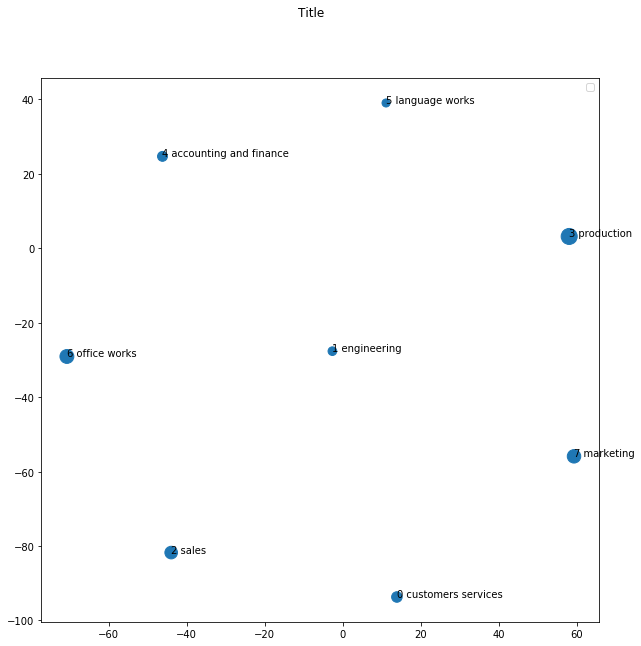

In [54]:
jan_stats = main_viz_2(jan_calc, centroid_jan, 8, dict_jd_dec_8)

No handles with labels found to put in legend.


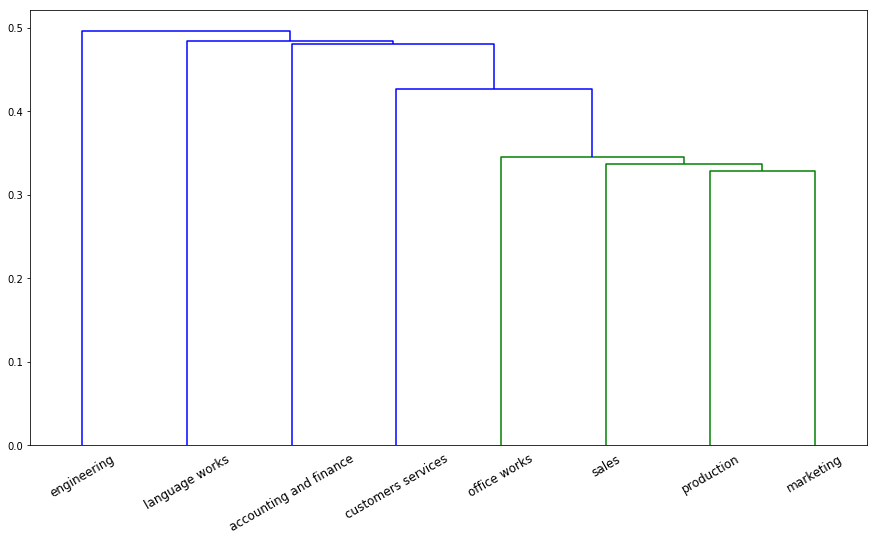

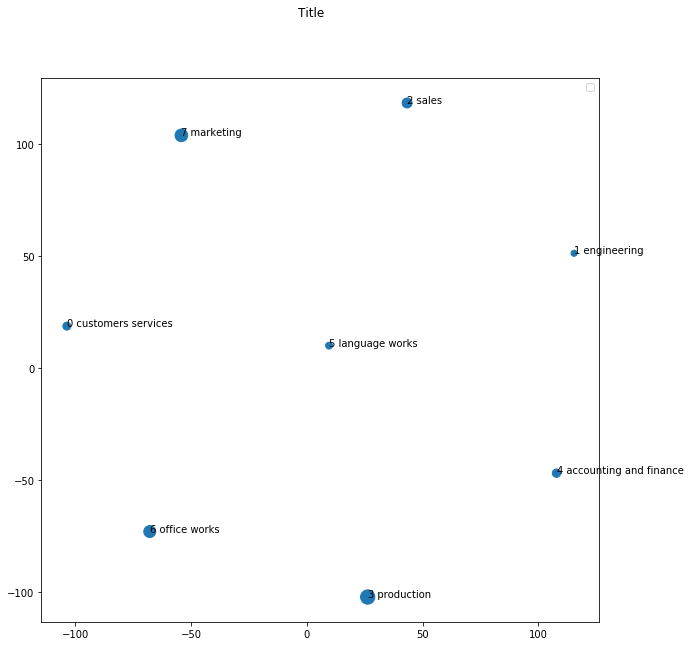

In [55]:
feb_stats = main_viz_2(feb_calc, centroid_feb, 8, dict_jd_dec_8)

No handles with labels found to put in legend.


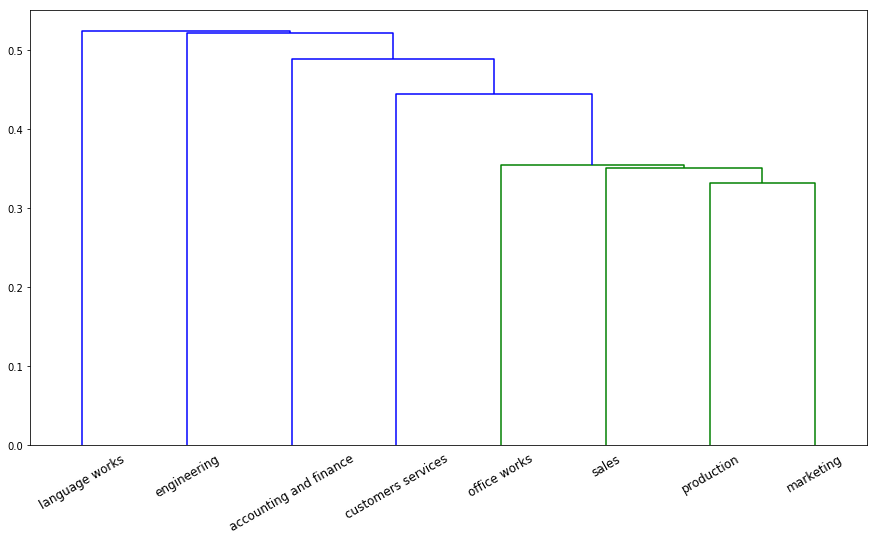

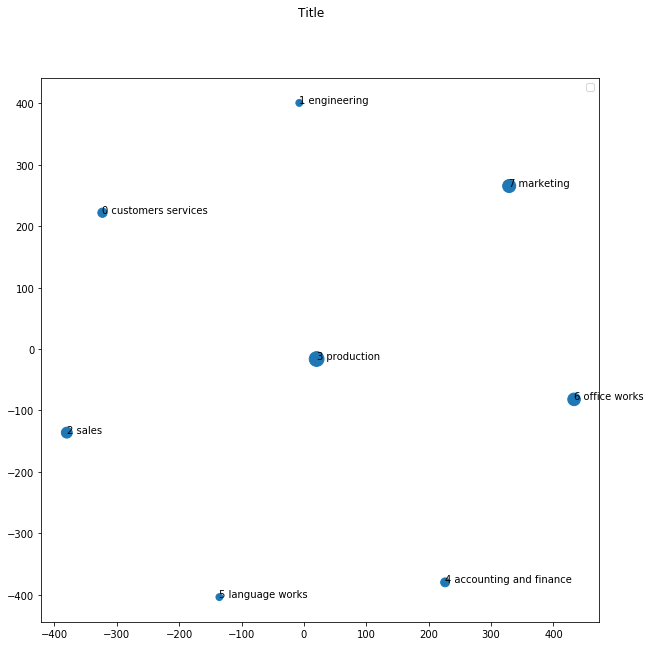

In [56]:
mar_stats = main_viz_2(mar_calc, centroid_mar, 8, dict_jd_dec_8)

In [21]:
dec_g.head()

idx  \
0  0     
1  1     
2  2     
3  3     
4  4     

                                                                     pos_en  \
0  MIS Support (annual contract).                                             
1  Loan Operations (operating loan)                                           
2  Digital Acquisition (Senior Officer -Manager)                              
3  Management Associate Programme 2019                                        
4  Sale Engineer (Electrical Engineer), Base on Manufacturing, Pathum Thani   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         jd_en  
0  Supporting documentation, including documentation of the audit department to present the data and verify the accuracy of the information in the system. Including analysis for the department to prepare weekly reports. Monthly coordination with other agencies as assigned.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Check the validity of documents and credit conditions before the loan is approved, the track conditions customers must comply with the set credit limits, then check the power to approve loans that conform to the policy. Bank / BOT liaise with the loan officer / loan approval. In the event of a problem or need clarification.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2  Focus mainly on digital customer acquisition, bring more potential lead for online telesales and boost up new account booking from online channel.  Increase the customer potential leads through partnership with digital partner.  Deal with digital partners on acquisition plan, prepare agreement, prepare proposal on digital acquisition program, and prepare marketing communication.  Closely manage digital-acquisition telesales team to ensure that telesales call back customers within SLA time and telesales has knowledge to answer customer inquiry.  Work with digital team, technology, and demand team on new digital acquisition project such as online account opening project, e-KYC, e-consent, etc.                                                                         

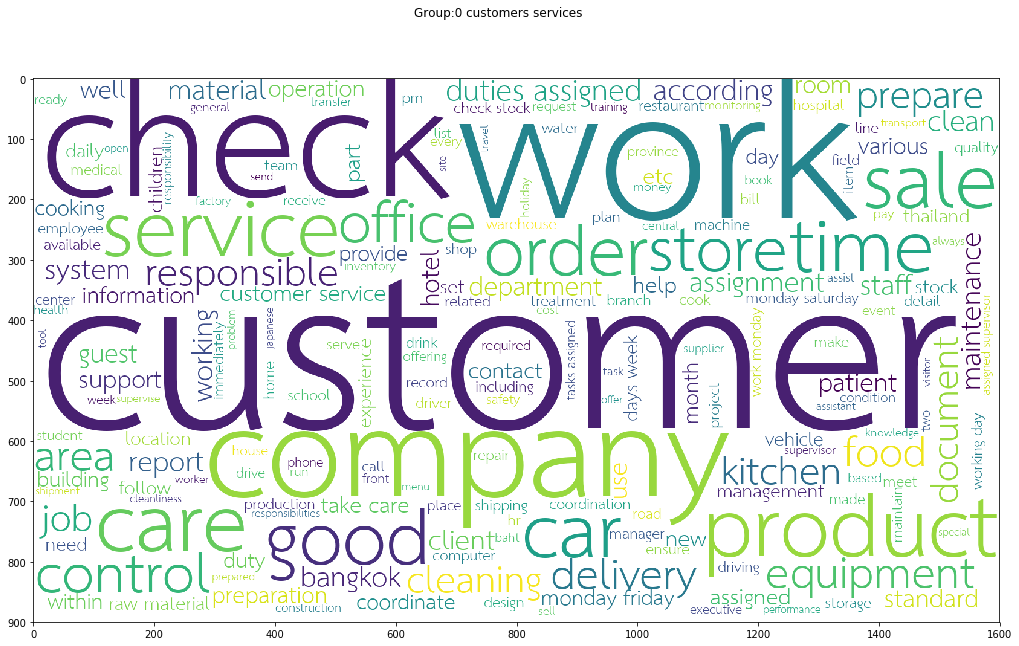

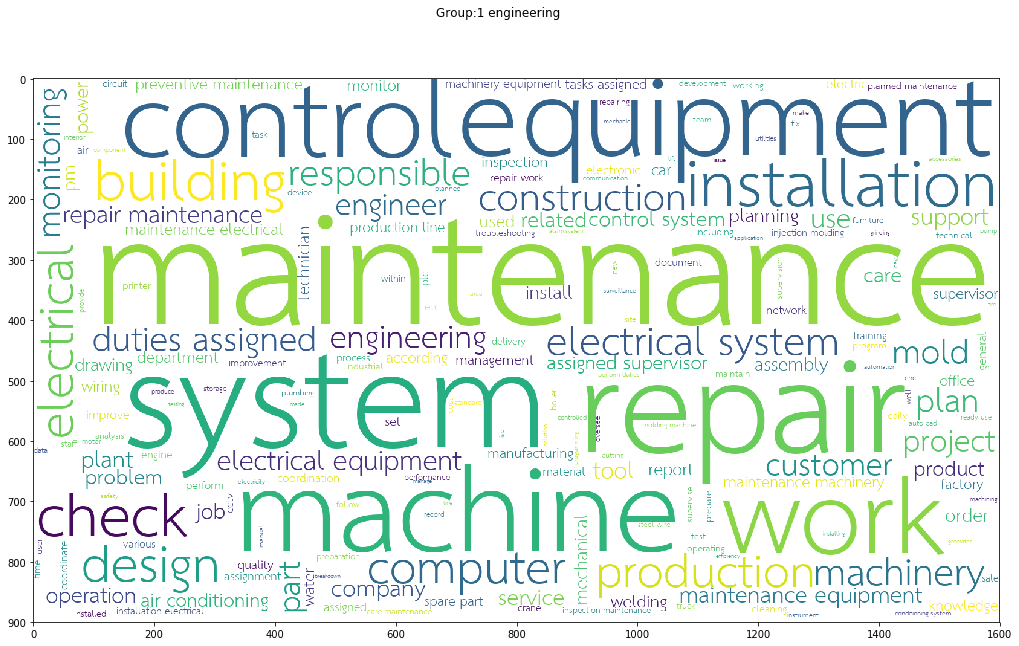

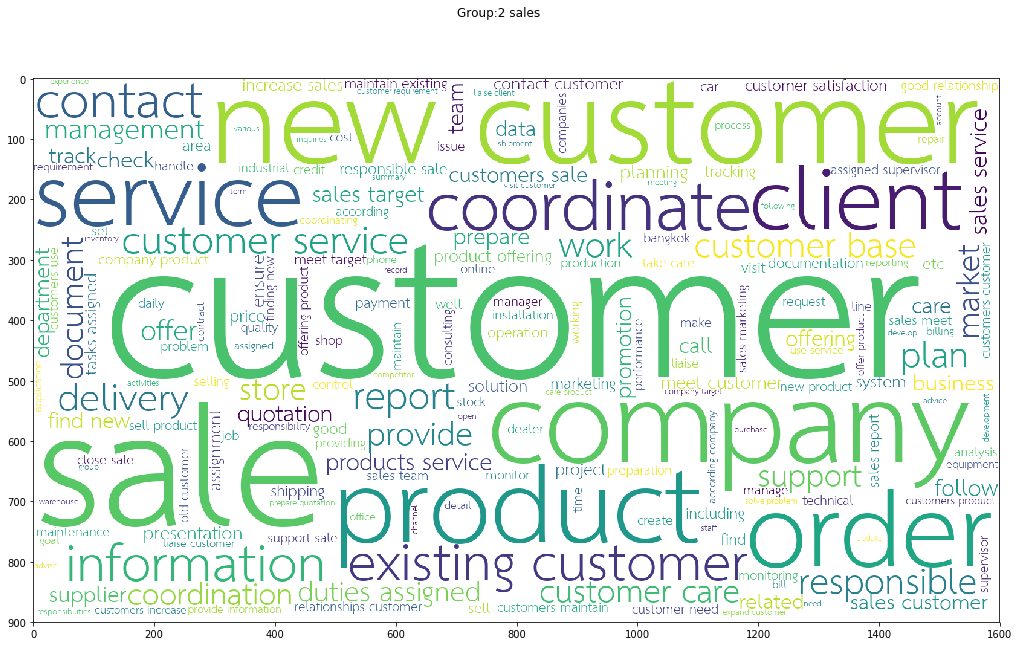

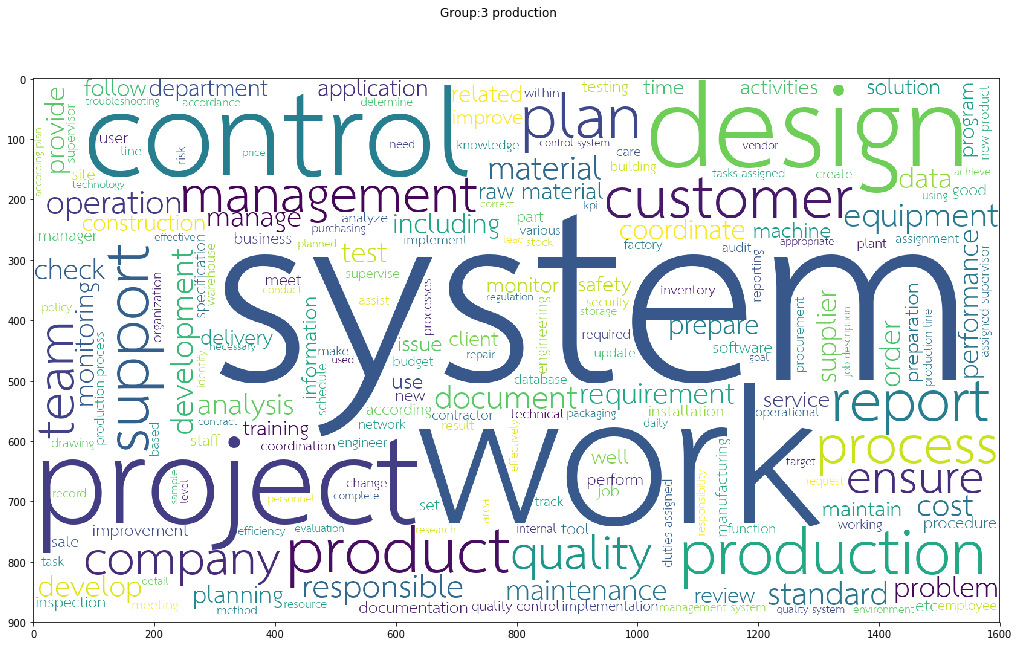

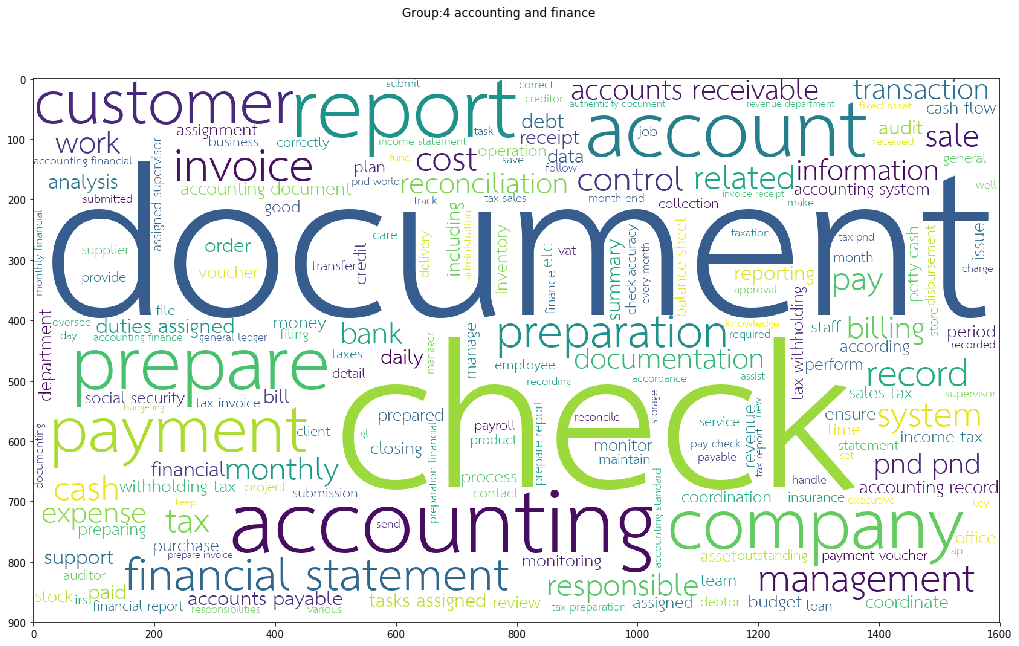

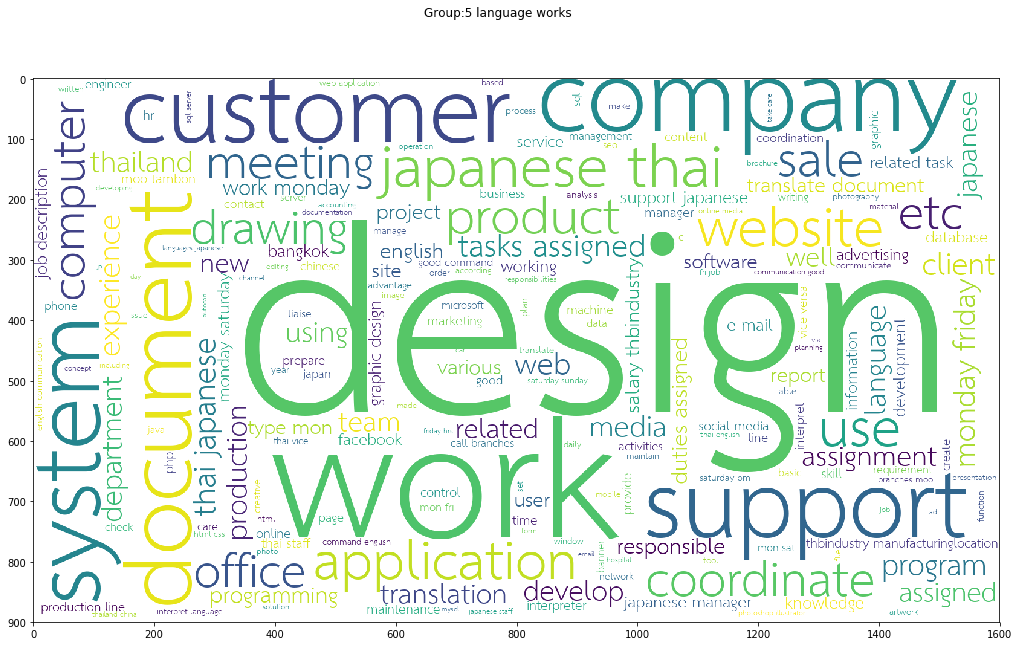

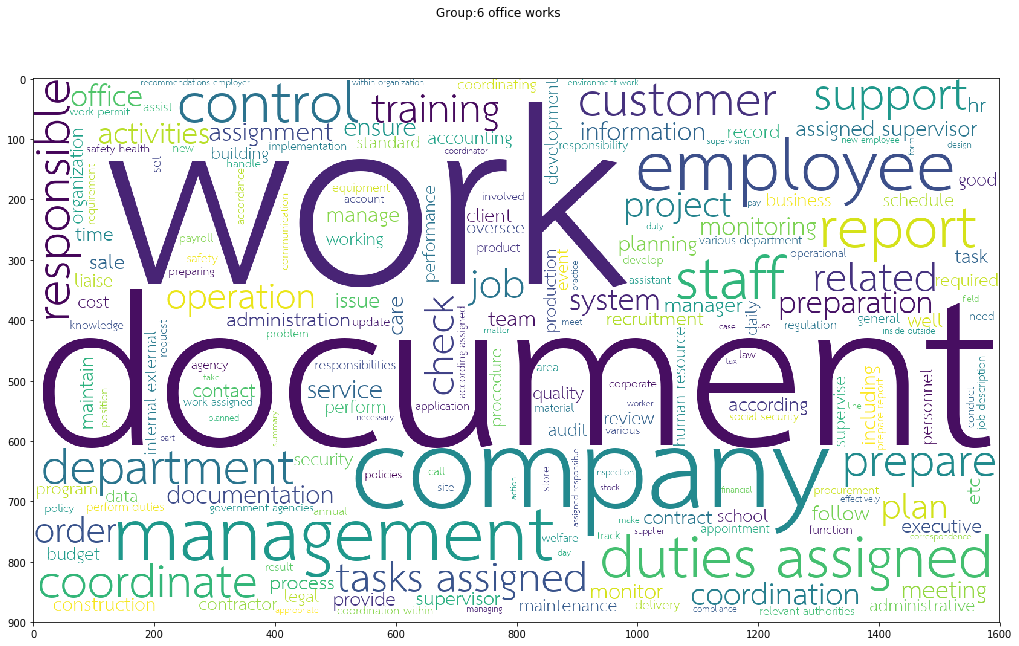

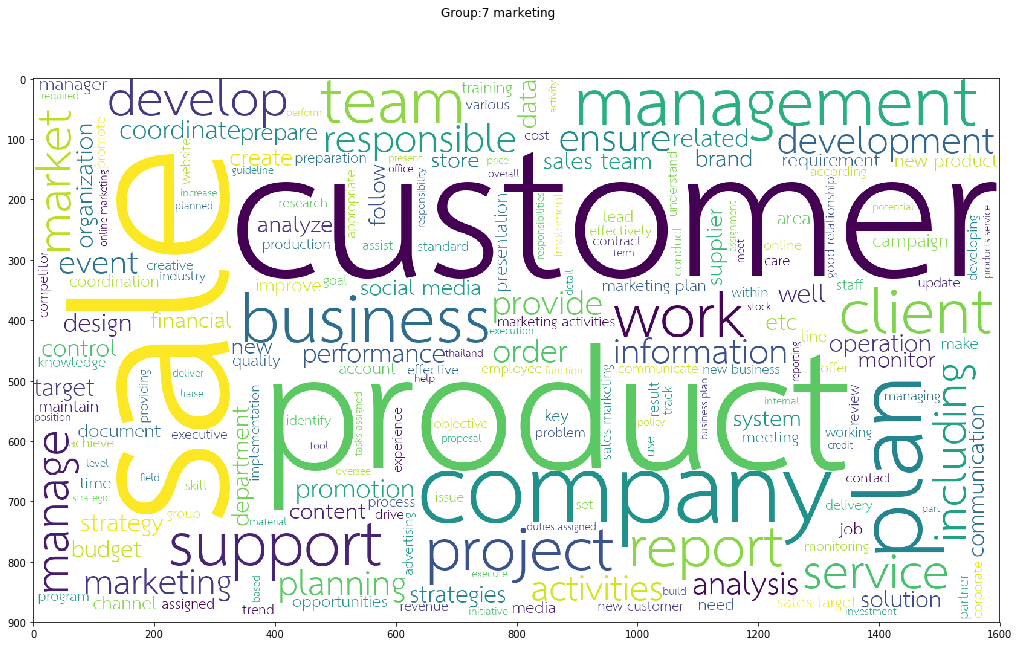

In [57]:
wc(dec_calc,np.arange(0,8),dict_jd_dec_8)

In [19]:
adecco.head()

Unnamed: 0  index  Unnamed: 0.1                        position  \
0  0           1      1             Accounting Analyst               
1  1           2      2             Accounting Assistant             
2  2           4      4             Accounting Executive / Officer   
3  3           6      6             Accounts Payable Accountant      
4  4           7      7             Accounts Receivable Accountant   

                                                                                                                                                                                                                                                                                          jd_en  \
0  Perform duties related to fixed-asset accounting, bank reconciliation, cost allocation, account closing, financial accounting and balance sheet accounts reconciliation. Review and monitor accounting controls to ensure accurate and timely financial records.                               
1  Handle general accounting functions, including accounts payable, accounts receivable and general ledger. Responsible for balancing and reconciliations. Specialise in one area of the accounting function and understand bookkeeping procedures.                                               
2  Handle cash receipts, expenditures, investments, purchasing, inventory, assets and payroll. Record all transactions. Prepare and submit VAT reports. Assist with assets and inventory control and handle general accounting functions.                                                         
3  Perform any combination of routine calculating, including posting business transactions, processing invoices, and verifying financial data to be used in maintaining accounts payable records. Verify accurate information and/or data. Make sure that the payment is received as scheduled.   
4  Prepare invoices, receipts and tax invoices.  Follow up on customer payment and prepare VAT reports.                                                                                                                                                                                           

                                                        url variable    value  \
0  https://adecco.co.th/salary-guide/2019/00001/7#job-des    newgrad  21500.0   
1  https://adecco.co.th/salary-guide/2019/00001/9#job-des    newgrad  20000.0   
2  https://adecco.co.th/salary-guide/2019/00001/2#job-des    newgrad  20000.0   
3  https://adecco.co.th/salary-guide/2019/00001/248#job-des  newgrad  21500.0   
4  https://adecco.co.th/salary-guide/2019/00001/4#job-des    newgrad  21500.0   

   newgrad  senior  
0  1        0       
1  1        0       
2  1        0       
3  1        0       
4  1        0

In [27]:
adecco_calc, centroid_adecco, vec_adecco = main_cluster(adecco)

(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)


In [28]:
adecco_calc.head()

k_jd  Unnamed: 0  index  Unnamed: 0.1                        position  \
0  4     0           1      1             Accounting Analyst               
1  4     1           2      2             Accounting Assistant             
2  4     2           4      4             Accounting Executive / Officer   
3  4     3           6      6             Accounts Payable Accountant      
4  4     4           7      7             Accounts Receivable Accountant   

                                                                                                                                                                                                                                                                                          jd_en  \
0  Perform duties related to fixed-asset accounting, bank reconciliation, cost allocation, account closing, financial accounting and balance sheet accounts reconciliation. Review and monitor accounting controls to ensure accurate and timely financial records.                               
1  Handle general accounting functions, including accounts payable, accounts receivable and general ledger. Responsible for balancing and reconciliations. Specialise in one area of the accounting function and understand bookkeeping procedures.                                               
2  Handle cash receipts, expenditures, investments, purchasing, inventory, assets and payroll. Record all transactions. Prepare and submit VAT reports. Assist with assets and inventory control and handle general accounting functions.                                                         
3  Perform any combination of routine calculating, including posting business transactions, processing invoices, and verifying financial data to be used in maintaining accounts payable records. Verify accurate information and/or data. Make sure that the payment is received as scheduled.   
4  Prepare invoices, receipts and tax invoices.  Follow up on customer payment and prepare VAT reports.                                                                                                                                                                                           

                                                        url variable    value  \
0  https://adecco.co.th/salary-guide/2019/00001/7#job-des    newgrad  21500.0   
1  https://adecco.co.th/salary-guide/2019/00001/9#job-des    newgrad  20000.0   
2  https://adecco.co.th/salary-guide/2019/00001/2#job-des    newgrad  20000.0   
3  https://adecco.co.th/salary-guide/2019/00001/248#job-des  newgrad  21500.0   
4  https://adecco.co.th/salary-guide/2019/00001/4#job-des    newgrad  21500.0   

   newgrad  senior  
0  1        0       
1  1        0       
2  1        0       
3  1        0       
4  1        0

In [29]:
centroid_adecco

array([[-0.0470545 ,  0.09856345, -0.00235269, ..., -0.02159635,
         0.02921209,  0.02301442],
       [-0.04855774,  0.03712971,  0.06170732, ..., -0.04879522,
        -0.01136285, -0.078949  ],
       [-0.05725693,  0.02775417, -0.01759715, ..., -0.00197372,
         0.04213699, -0.0818167 ],
       ...,
       [-0.02515132, -0.01113809, -0.02013312, ..., -0.07409517,
        -0.04195858,  0.02263193],
       [-0.0390766 ,  0.01865958,  0.00460288, ..., -0.04515688,
        -0.0043762 , -0.01820276],
       [-0.04489919,  0.02167061, -0.00528597, ..., -0.01393685,
         0.01693759, -0.03094325]])

In [30]:
adecco_calc.head()

k_jd  Unnamed: 0  index  Unnamed: 0.1                        position  \
0  4     0           1      1             Accounting Analyst               
1  4     1           2      2             Accounting Assistant             
2  4     2           4      4             Accounting Executive / Officer   
3  4     3           6      6             Accounts Payable Accountant      
4  4     4           7      7             Accounts Receivable Accountant   

                                                                                                                                                                                                                                                                                          jd_en  \
0  Perform duties related to fixed-asset accounting, bank reconciliation, cost allocation, account closing, financial accounting and balance sheet accounts reconciliation. Review and monitor accounting controls to ensure accurate and timely financial records.                               
1  Handle general accounting functions, including accounts payable, accounts receivable and general ledger. Responsible for balancing and reconciliations. Specialise in one area of the accounting function and understand bookkeeping procedures.                                               
2  Handle cash receipts, expenditures, investments, purchasing, inventory, assets and payroll. Record all transactions. Prepare and submit VAT reports. Assist with assets and inventory control and handle general accounting functions.                                                         
3  Perform any combination of routine calculating, including posting business transactions, processing invoices, and verifying financial data to be used in maintaining accounts payable records. Verify accurate information and/or data. Make sure that the payment is received as scheduled.   
4  Prepare invoices, receipts and tax invoices.  Follow up on customer payment and prepare VAT reports.                                                                                                                                                                                           

                                                        url variable    value  \
0  https://adecco.co.th/salary-guide/2019/00001/7#job-des    newgrad  21500.0   
1  https://adecco.co.th/salary-guide/2019/00001/9#job-des    newgrad  20000.0   
2  https://adecco.co.th/salary-guide/2019/00001/2#job-des    newgrad  20000.0   
3  https://adecco.co.th/salary-guide/2019/00001/248#job-des  newgrad  21500.0   
4  https://adecco.co.th/salary-guide/2019/00001/4#job-des    newgrad  21500.0   

   newgrad  senior  
0  1        0       
1  1        0       
2  1        0       
3  1        0       
4  1        0

In [31]:
sum_dist = np.sum(np.linalg.norm(vec_adecco - centroid_adecco[0],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[1],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[2],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[3],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[4],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[5],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[6],axis =1).reshape(1,766)+
np.linalg.norm(vec_adecco - centroid_adecco[7],axis =1).reshape(1,766), axis = 0)

In [32]:
sum_dist.shape

(766,)

In [33]:
np.linalg.norm(vec_adecco - centroid_dec[0],axis=1)/sum_dist

array([0.12890413, 0.12743548, 0.1301574 , 0.12418321, 0.12211743,
       0.13637462, 0.12024487, 0.12300351, 0.13096791, 0.13343559,
       0.12695073, 0.12854084, 0.1221369 , 0.11055583, 0.11190224,
       0.13577607, 0.11413243, 0.12801961, 0.10688377, 0.12675974,
       0.12342859, 0.13135662, 0.12731941, 0.12573581, 0.12108511,
       0.1389088 , 0.14269763, 0.13441034, 0.12761833, 0.11632546,
       0.12280453, 0.12212765, 0.12651387, 0.14058323, 0.13483068,
       0.12511957, 0.1264149 , 0.12777908, 0.13011341, 0.12851232,
       0.12317734, 0.1212008 , 0.12755168, 0.12369436, 0.12369436,
       0.12452278, 0.13358984, 0.12723845, 0.13177508, 0.1218968 ,
       0.1141368 , 0.11687443, 0.13400311, 0.12437625, 0.13624101,
       0.12423511, 0.11739952, 0.13207885, 0.13445557, 0.14109307,
       0.09923286, 0.13198554, 0.11932957, 0.11593697, 0.12058058,
       0.13445557, 0.11733637, 0.11985276, 0.12356708, 0.12452278,
       0.11641571, 0.12759924, 0.12964985, 0.13486996, 0.12788

In [38]:
d_group0 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[0], axis = 1)/sum_dist)
d_group1 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[1], axis = 1)/sum_dist)
d_group2 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[2], axis = 1)/sum_dist)
d_group3 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[3], axis = 1)/sum_dist)
d_group4 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[4], axis = 1)/sum_dist)
d_group5 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[5], axis = 1)/sum_dist)
d_group6 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[6], axis = 1)/sum_dist)
d_group7 = pd.DataFrame(-np.linalg.norm(vec_adecco - centroid_dec[7], axis = 1)/sum_dist)
#d_sci = pd.DataFrame(np.linalg.norm(vec_adecco-sci, axis =1))

d_group0.columns = ["d_group0"]
d_group1.columns = ["d_group1"]
d_group2.columns = ["d_group2"]
d_group3.columns = ["d_group3"]
d_group4.columns = ["d_group4"]
d_group5.columns = ["d_group5"]
d_group6.columns = ["d_group6"]
d_group7.columns = ["d_group7"]
#d_sci.columns = ["d_sci"]

In [39]:
normdist= pd.concat([d_group0,d_group1, d_group2, d_group3, d_group4, d_group5, d_group6, d_group7], axis=1)

In [40]:
adecco_calc=pd.concat([adecco_calc, normdist], axis=1)

In [41]:
adecco_calc.columns

Index(['k_jd', 'Unnamed: 0', 'index', 'Unnamed: 0.1', 'position', 'jd_en',
       'url', 'variable', 'wage', 'newgrad', 'senior', 'd_group0', 'd_group1',
       'd_group2', 'd_group3', 'd_group4', 'd_group5', 'd_group6', 'd_group7'],
      dtype='object')

In [42]:
adecco_calc.head(5)

k_jd  Unnamed: 0  index  Unnamed: 0.1                        position  \
0  4     0           1      1             Accounting Analyst               
1  4     1           2      2             Accounting Assistant             
2  4     2           4      4             Accounting Executive / Officer   
3  4     3           6      6             Accounts Payable Accountant      
4  4     4           7      7             Accounts Receivable Accountant   

                                                                                                                                                                                                                                                                                          jd_en  \
0  Perform duties related to fixed-asset accounting, bank reconciliation, cost allocation, account closing, financial accounting and balance sheet accounts reconciliation. Review and monitor accounting controls to ensure accurate and timely financial records.                               
1  Handle general accounting functions, including accounts payable, accounts receivable and general ledger. Responsible for balancing and reconciliations. Specialise in one area of the accounting function and understand bookkeeping procedures.                                               
2  Handle cash receipts, expenditures, investments, purchasing, inventory, assets and payroll. Record all transactions. Prepare and submit VAT reports. Assist with assets and inventory control and handle general accounting functions.                                                         
3  Perform any combination of routine calculating, including posting business transactions, processing invoices, and verifying financial data to be used in maintaining accounts payable records. Verify accurate information and/or data. Make sure that the payment is received as scheduled.   
4  Prepare invoices, receipts and tax invoices.  Follow up on customer payment and prepare VAT reports.                                                                                                                                                                                           

                                                        url variable     wage  \
0  https://adecco.co.th/salary-guide/2019/00001/7#job-des    newgrad  21500.0   
1  https://adecco.co.th/salary-guide/2019/00001/9#job-des    newgrad  20000.0   
2  https://adecco.co.th/salary-guide/2019/00001/2#job-des    newgrad  20000.0   
3  https://adecco.co.th/salary-guide/2019/00001/248#job-des  newgrad  21500.0   
4  https://adecco.co.th/salary-guide/2019/00001/4#job-des    newgrad  21500.0   

   newgrad  senior  d_group0  d_group1  d_group2  d_group3  d_group4  \
0  1        0      -0.128904 -0.143886 -0.132249 -0.114645 -0.080565   
1  1        0      -0.127435 -0.139479 -0.131526 -0.121473 -0.088873   
2  1        0      -0.130157 -0.141845 -0.121972 -0.119682 -0.090915   
3  1        0      -0.124183 -0.141483 -0.121755 -0.111483 -0.083815   
4  1        0      -0.122117 -0.134571 -0.117491 -0.124095 -0.092325   

   d_group5  d_group6  d_group7  
0 -0.140878 -0.111435 -0.117172  
1 -0.135696 -0.110919 -0.121566  
2 -0.146684 -0.116694 -0.117831  
3 -0.135697 -0.112398 -0.116126  
4 -0.134295 -0.119101 -0.122728

In [44]:
adecco_calc = adecco_calc.rename(columns={"d_group0": "customers_services", "d_group1": "engineering",
                                          "d_group2":"sales","d_group3": "production", 
                                          "d_group4":"accounting_and_finance", "d_group5":"language_works",
                                          "d_group6": "office_works", "d_group7":"marketing",
                                          "marketings":"marketing", "value":"wage", "quality_control": "production"})

In [45]:
adecco_calc.head()

k_jd  Unnamed: 0  index  Unnamed: 0.1                        position  \
0  4     0           1      1             Accounting Analyst               
1  4     1           2      2             Accounting Assistant             
2  4     2           4      4             Accounting Executive / Officer   
3  4     3           6      6             Accounts Payable Accountant      
4  4     4           7      7             Accounts Receivable Accountant   

                                                                                                                                                                                                                                                                                          jd_en  \
0  Perform duties related to fixed-asset accounting, bank reconciliation, cost allocation, account closing, financial accounting and balance sheet accounts reconciliation. Review and monitor accounting controls to ensure accurate and timely financial records.                               
1  Handle general accounting functions, including accounts payable, accounts receivable and general ledger. Responsible for balancing and reconciliations. Specialise in one area of the accounting function and understand bookkeeping procedures.                                               
2  Handle cash receipts, expenditures, investments, purchasing, inventory, assets and payroll. Record all transactions. Prepare and submit VAT reports. Assist with assets and inventory control and handle general accounting functions.                                                         
3  Perform any combination of routine calculating, including posting business transactions, processing invoices, and verifying financial data to be used in maintaining accounts payable records. Verify accurate information and/or data. Make sure that the payment is received as scheduled.   
4  Prepare invoices, receipts and tax invoices.  Follow up on customer payment and prepare VAT reports.                                                                                                                                                                                           

                                                        url variable     wage  \
0  https://adecco.co.th/salary-guide/2019/00001/7#job-des    newgrad  21500.0   
1  https://adecco.co.th/salary-guide/2019/00001/9#job-des    newgrad  20000.0   
2  https://adecco.co.th/salary-guide/2019/00001/2#job-des    newgrad  20000.0   
3  https://adecco.co.th/salary-guide/2019/00001/248#job-des  newgrad  21500.0   
4  https://adecco.co.th/salary-guide/2019/00001/4#job-des    newgrad  21500.0   

   newgrad  senior  customers_services  engineering     sales  production  \
0  1        0      -0.128904           -0.143886    -0.132249 -0.114645     
1  1        0      -0.127435           -0.139479    -0.131526 -0.121473     
2  1        0      -0.130157           -0.141845    -0.121972 -0.119682     
3  1        0      -0.124183           -0.141483    -0.121755 -0.111483     
4  1        0      -0.122117           -0.134571    -0.117491 -0.124095     

   accounting_and_finance  language_works  office_works  marketing  
0 -0.080565               -0.140878       -0.111435     -0.117172   
1 -0.088873               -0.135696       -0.110919     -0.121566   
2 -0.090915               -0.146684       -0.116694     -0.117831   
3 -0.083815               -0.135697       -0.112398     -0.116126   
4 -0.092325               -0.134295       -0.119101     -0.122728

In [46]:
X = adecco_calc[["customers_services", "engineering", "sales", "production", "accounting_and_finance", 
                 "language_works", "office_works", "marketing", "newgrad", "senior"]]
X = sm.add_constant(X)
Y = np.log(adecco_calc['wage'])

/Users/sikawit/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [47]:
model_ols = sm.OLS(Y, X).fit()
predictions = model_ols.predict(X) 

In [48]:
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     171.4
Date:                Wed, 15 May 2019   Prob (F-statistic):          1.14e-186
Time:                        20:54:41   Log-Likelihood:                -325.32
No. Observations:                 766   AIC:                             672.6
Df Residuals:                     755   BIC:                             723.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11.0472      0.747     14.789      0.000       9.581      12.514
customers_services       -15.7890      3.032     -5.208      0.000     -21.741      -9.837
engineering               10.5283      2.250      4.678      0.000       6.110      14.946
sales                     -7.8899      2.257     -3.495      0.001     -12.321      -3.458
production               -10.1945      2.465     -4.136      0.000     -15.034      -5.355
accounting_and_finance     3.6898      1.524      2.422      0.016       0.699       6.681
language_works            -2.9823      1.789     -1.667      0.096      -6.494       0.530
office_works               2.4608      2.308      1.066      0.287      -2.070       6.992
marketing                 24.7426      3.062      8.082      0.000      18.732      30.753
newgrad                   -0.5284      0.039    -13.704      0.000      -0.604      -0.453
senior                     0.7092      0.031     22.678      0.000       0.648       0.771
==============================================================================
Omnibus:                       56.065   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.712
Skew:                           0.666   Prob(JB):                     1.98e-15
Kurtosis:                       3.587   Cond. No.                         376.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
for g in range(8):
    print(str(g),np.mean(adecco_calc[adecco_calc.k_jd == g].wage),
          np.std(adecco_calc[adecco_calc.k_jd == g].wage),
          (adecco_calc[adecco_calc.k_jd == g].wage).shape)


0 27500.0 9354.143466934853 (3,)
1 45678.57142857143 28188.211278866933 (28,)
2 54940.67796610169 37904.66237877389 (59,)
3 58250.0 38526.577759743355 (294,)
4 68268.29268292683 73023.22530312143 (41,)
5 45932.43243243243 19748.130996807173 (37,)
6 61257.142857142855 51091.10044046504 (105,)
7 90630.65326633166 71933.84394426845 (199,)


In [125]:
np.mean(adecco_calc.wage)

66180.8093994778

No handles with labels found to put in legend.


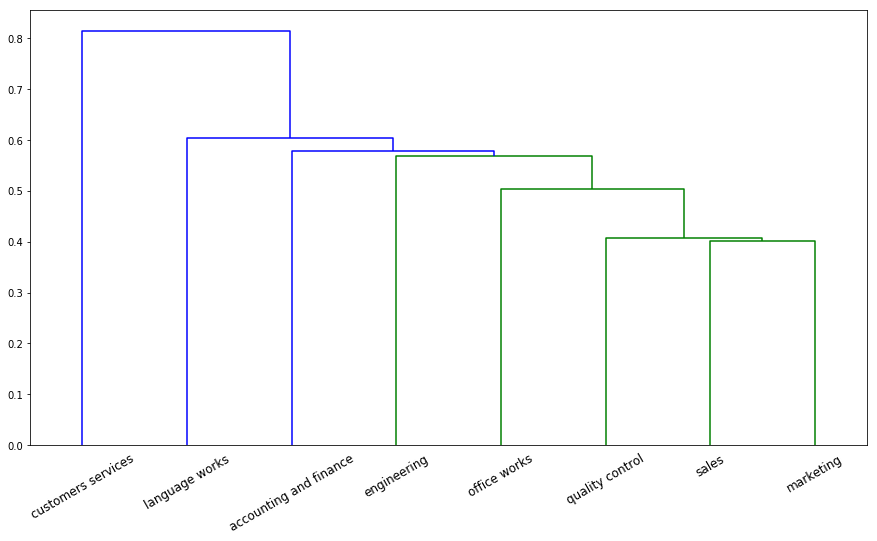

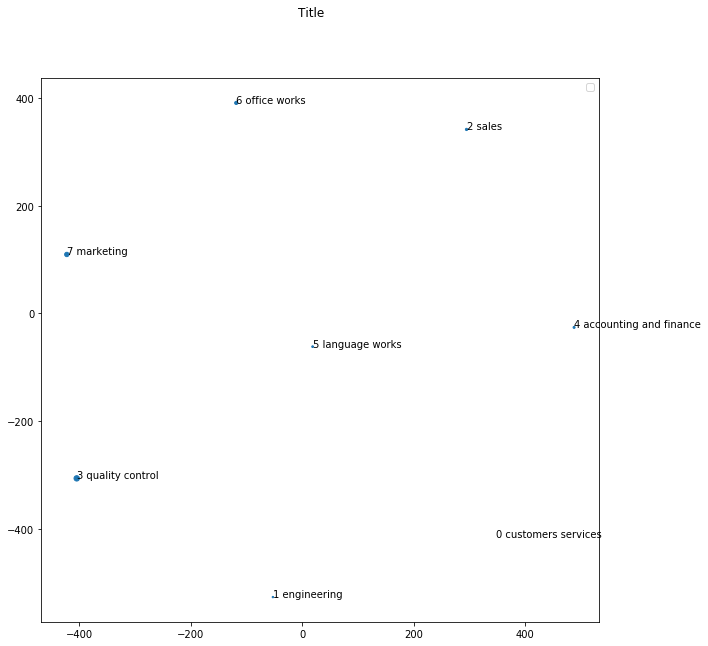

In [49]:
adecco_stats = main_viz_2(adecco_calc, centroid_adecco, 8, dict_jd_dec_8)

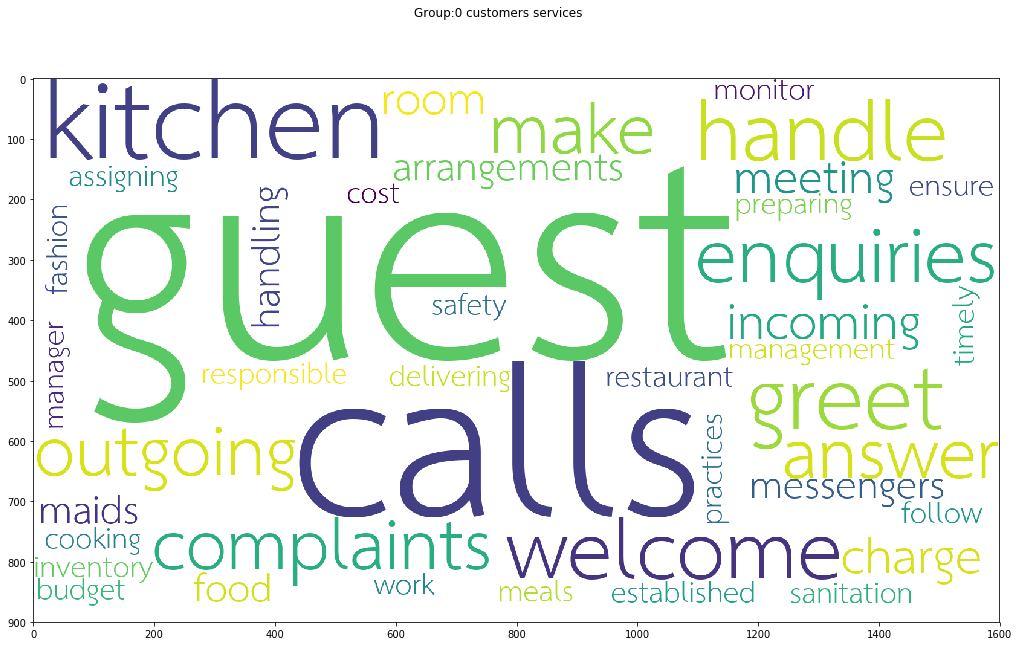

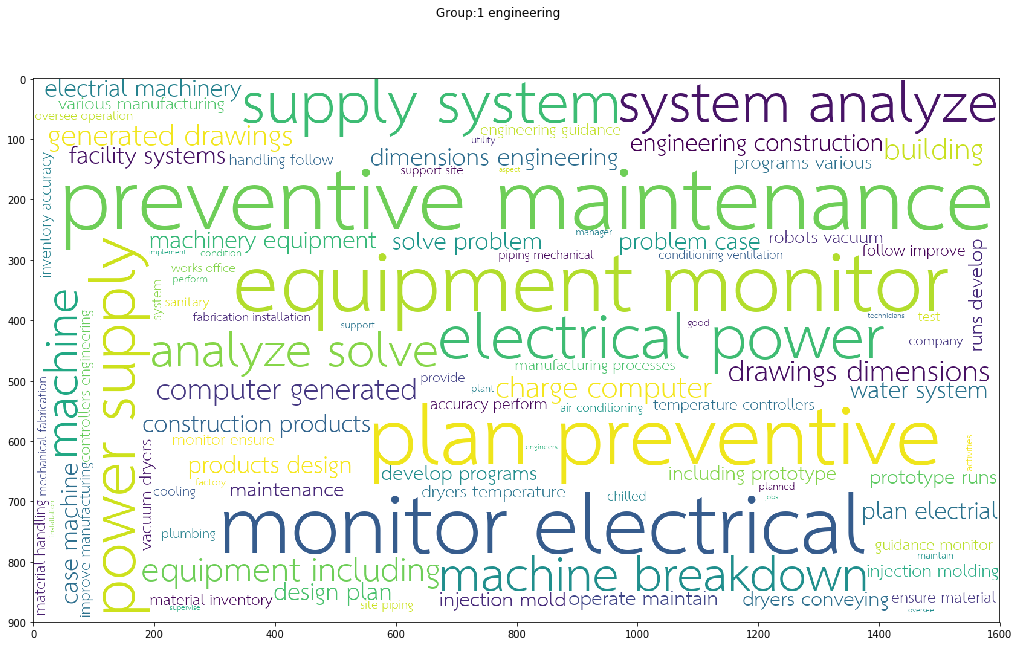

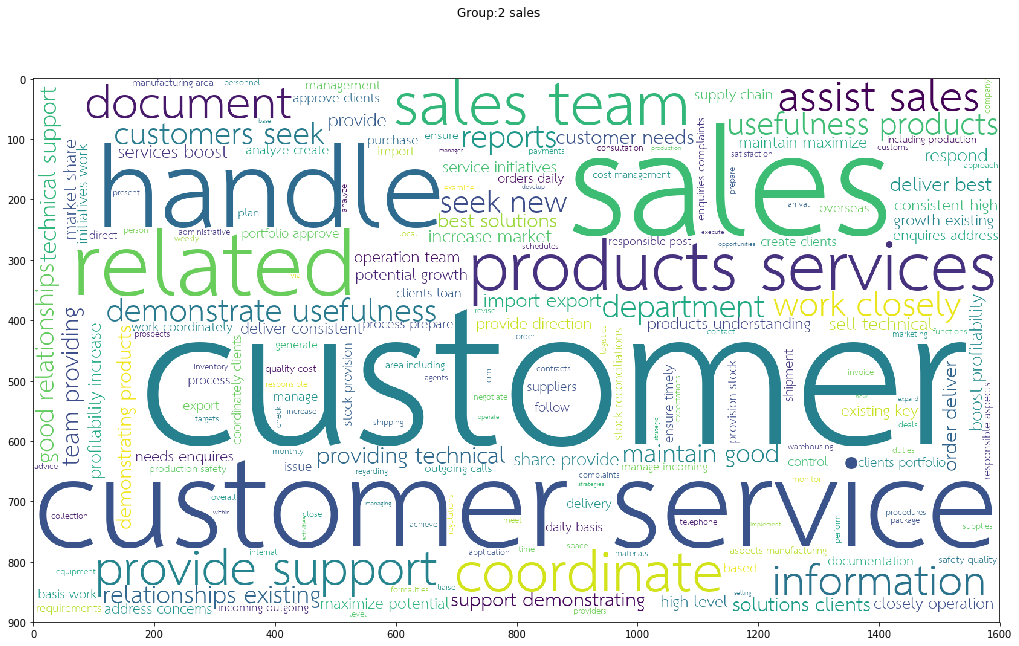

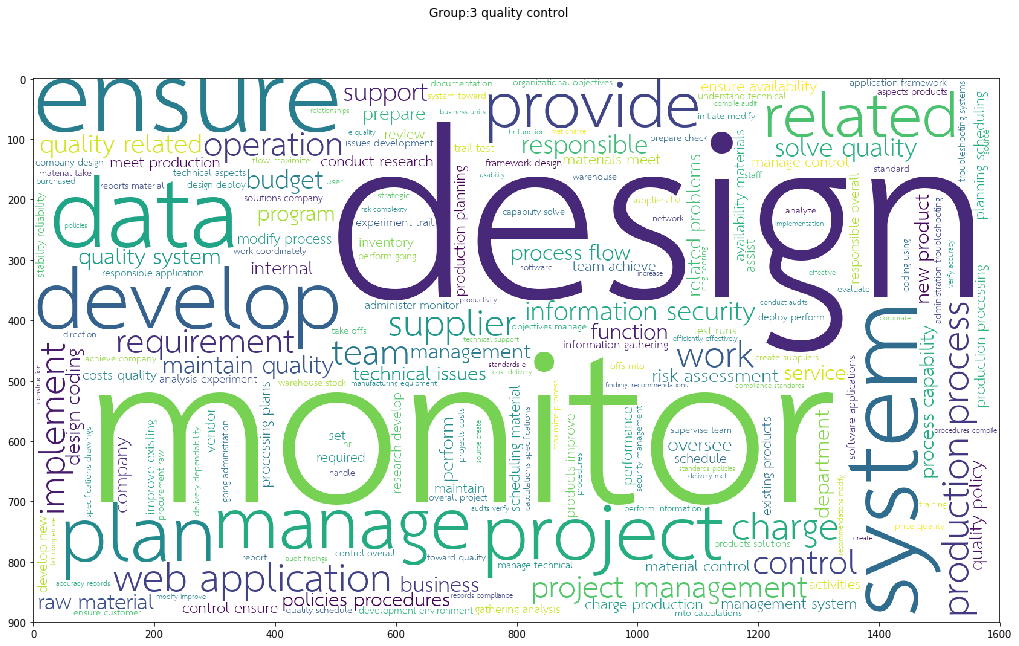

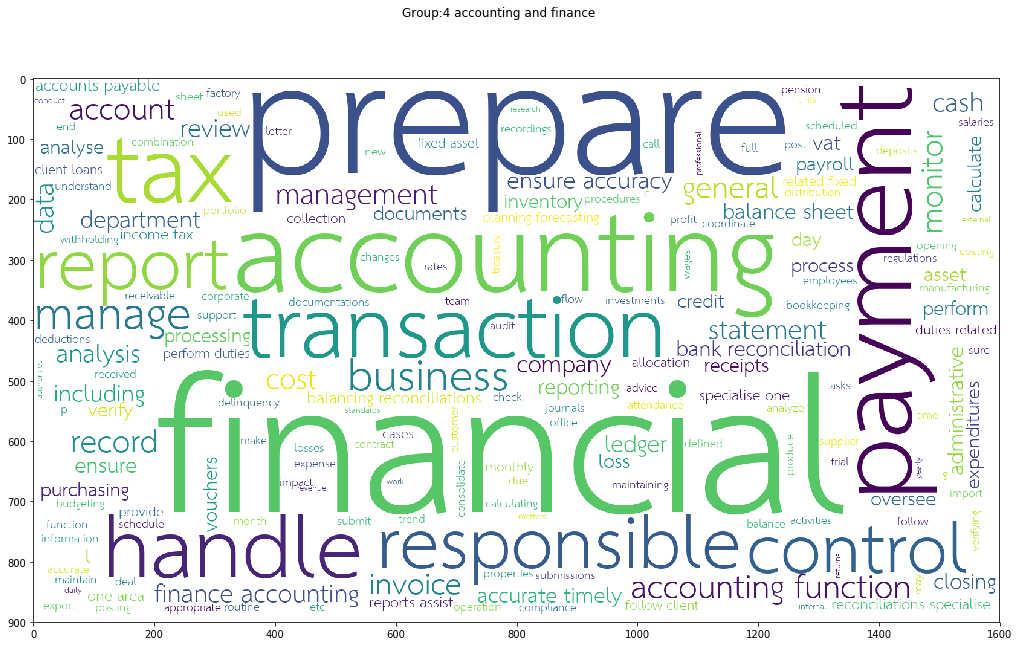

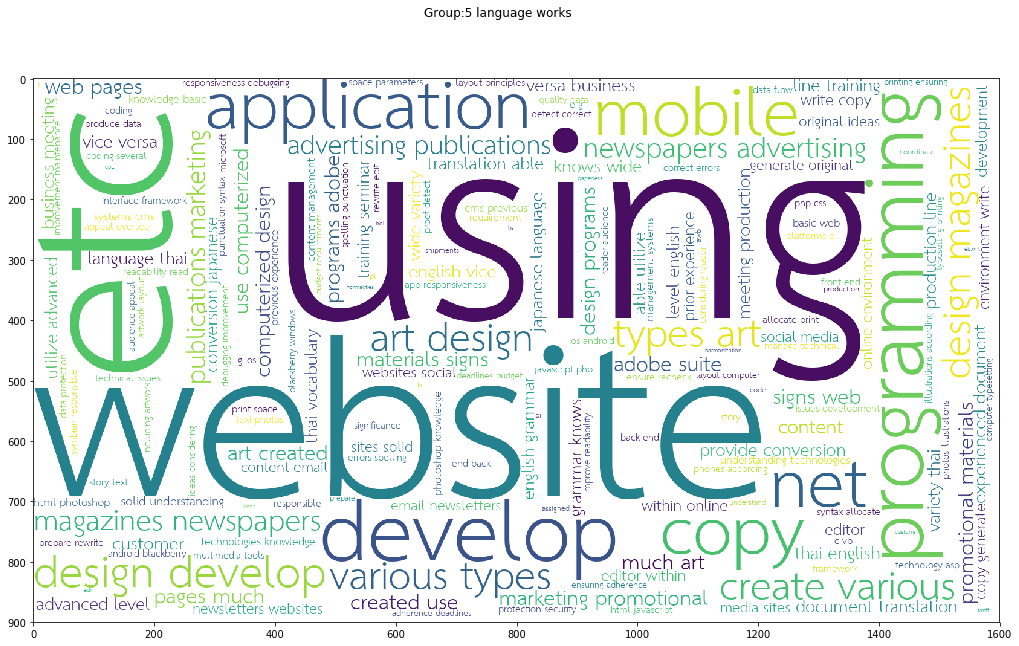

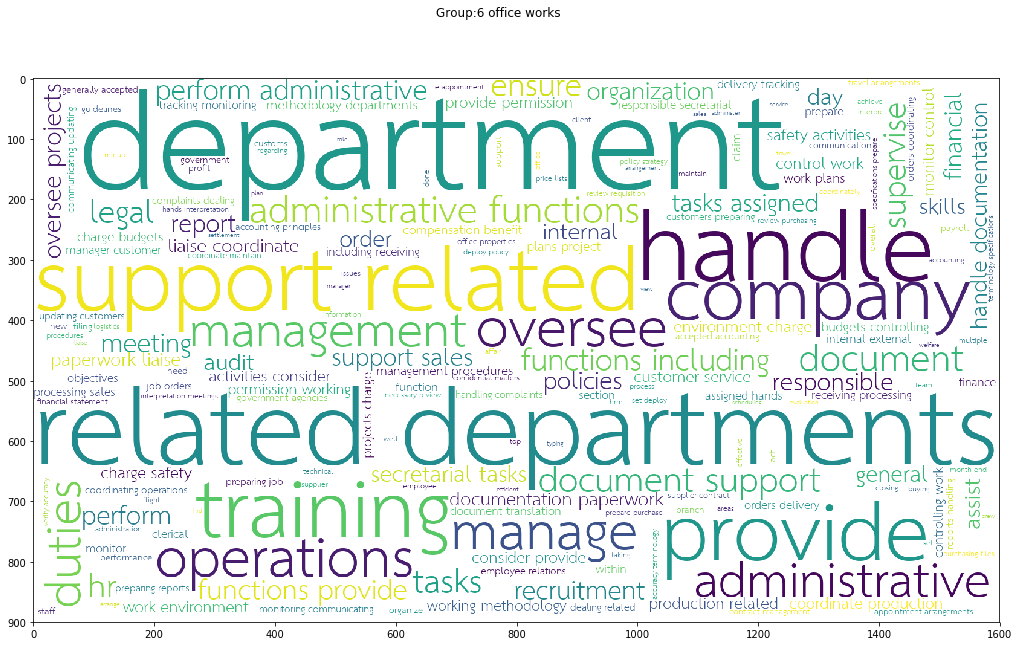

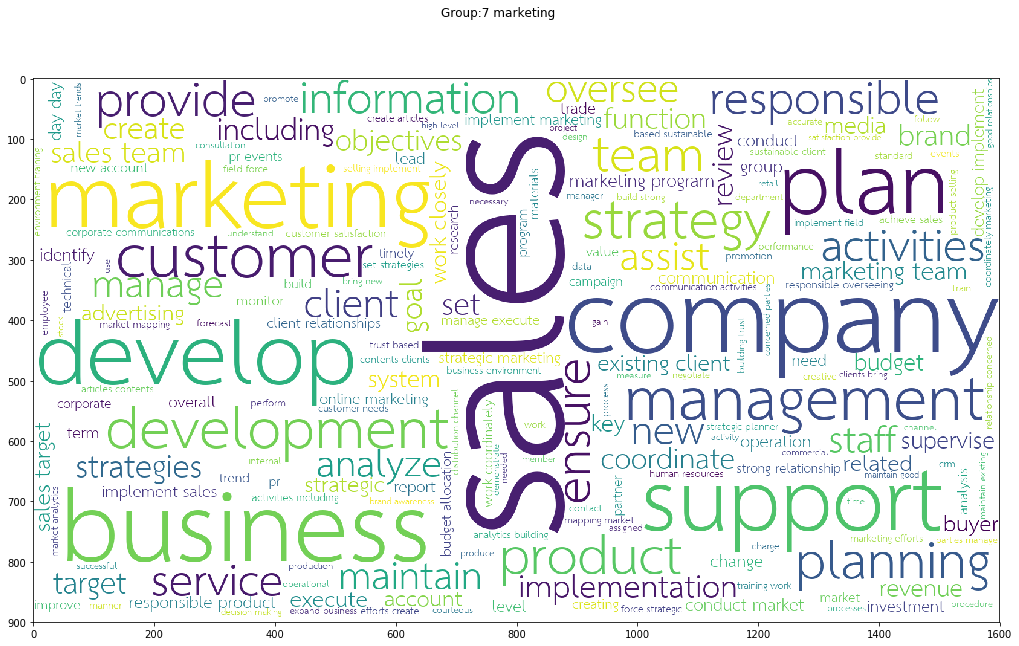

In [116]:
wc(adecco_calc,np.arange(0,8),dict_jd_dec_8)

In [269]:
d0 = np.linalg.norm((vec_adecco - centroid_dec[0]), axis=1)
d1 = np.linalg.norm((vec_adecco - centroid_dec[1]), axis=1)
d2 = np.linalg.norm((vec_adecco - centroid_dec[2]), axis=1)
d3 = np.linalg.norm((vec_adecco - centroid_dec[3]), axis=1)
d4 = np.linalg.norm((vec_adecco - centroid_dec[4]), axis=1)
d5 = np.linalg.norm((vec_adecco - centroid_dec[5]), axis=1)
d6 = np.linalg.norm((vec_adecco - centroid_dec[6]), axis=1)
d7 = np.linalg.norm((vec_adecco - centroid_dec[7]), axis=1)

In [270]:
sum_d =(d0+d1+d2+d3+d4+d5+d6+d7)

In [64]:
sum_d

NameError: name 'sum_d' is not defined

In [274]:
d0[0]+d1[0]+d2[0]+d3[0]+d4[0]+d5[0]+d6[0]+d7[0]

6.916050170080756

In [331]:
dist0 = np.log((d0/sum_d))
dist1 = np.log((d1/sum_d))
dist2 = np.log((d2/sum_d))
dist3 = np.log((d3/sum_d))
dist4 = np.log((d4/sum_d))
dist5 = np.log((d5/sum_d))
dist6 = np.log((d6/sum_d))
dist7 = np.log((d7/sum_d))

In [332]:
distance_df = pd.DataFrame([dist0, dist1, dist2, dist3, dist4, dist5, dist6, dist7]).T
distance_df.columns = ["dist0", "dist1", "dist2", "dist3", "dist4", "dist5", "dist6", "dist7"]

In [333]:
distance_df.head()

dist0     dist1     dist2     dist3     dist4     dist5     dist6  \
0 -2.017953 -1.907998 -1.992335 -2.135184 -2.487957 -1.929125 -2.163585   
1 -2.036843 -1.946542 -2.005248 -2.084762 -2.397241 -1.974036 -2.175657   
2 -2.024689 -1.938701 -2.089646 -2.108592 -2.383509 -1.905150 -2.133878   
3 -2.031479 -1.901055 -2.051222 -2.139367 -2.424629 -1.942811 -2.131188   
4 -2.068929 -1.971823 -2.107553 -2.052868 -2.348593 -1.973870 -2.093943   

      dist7  
0 -2.113380  
1 -2.083994  
2 -2.124185  
3 -2.098559  
4 -2.063940

In [334]:
adec_reg =adecco_calc[["wage","newgrad","senior"]]

In [335]:
regn = pd.concat([adec_reg,distance_df], axis =1)

In [338]:
X = regn[["dist0","dist2", "dist3", "dist5","dist7","newgrad","senior"]]
X = sm.add_constant(X)
Y = np.log(adecco_calc['wage'])


In [339]:
model_ols = sm.OLS(Y, X).fit()
predictions = model_ols.predict(X) 
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     235.4
Date:                Fri, 26 Apr 2019   Prob (F-statistic):          2.75e-185
Time:                        10:30:04   Log-Likelihood:                -336.82
No. Observations:                 766   AIC:                             689.6
Df Residuals:                     758   BIC:                             726.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.4554      1.207     14.457      0.000      15.085      19.826
dist0          2.2073      0.362      6.100      0.000       1.497       2.918
dist2          0.9888      0.204      4.849      0.000       0.589       1.389
dist3          0.8941      0.224      4.000      0.000       0.455       1.333
dist5          0.5964      0.178      3.351      0.001       0.247       0.946
dist7         -1.3217      0.200     -6.616      0.000      -1.714      -0.930
newgrad       -0.5336      0.039    -13.678      0.000      -0.610      -0.457
senior         0.7232      0.032     22.936      0.000       0.661       0.785
==============================================================================
Omnibus:                       60.639   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.215
Skew:                           0.688   Prob(JB):                     4.65e-17
Kurtosis:                       3.681   Cond. No.                         444.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
topwords(adecco_calc, range(8))

Group 0: calls kitchen greet welcome guests handle guest enquiries complaints make
Group 1: system equipment plan maintenance machines engineering monitor electrical material preventive
Group 2: sales customers customer products provide clients service support team handle
Group 3: quality process ensure design manage control production products perform data
Group 4: accounting financial prepare tax handle responsible reports transactions payment manage
Group 5: design develop web copy website art using production knowledge content
Group 6: departments related support provide administrative handle functions management tasks oversee
Group 7: marketing sales business company develop product support management responsible team


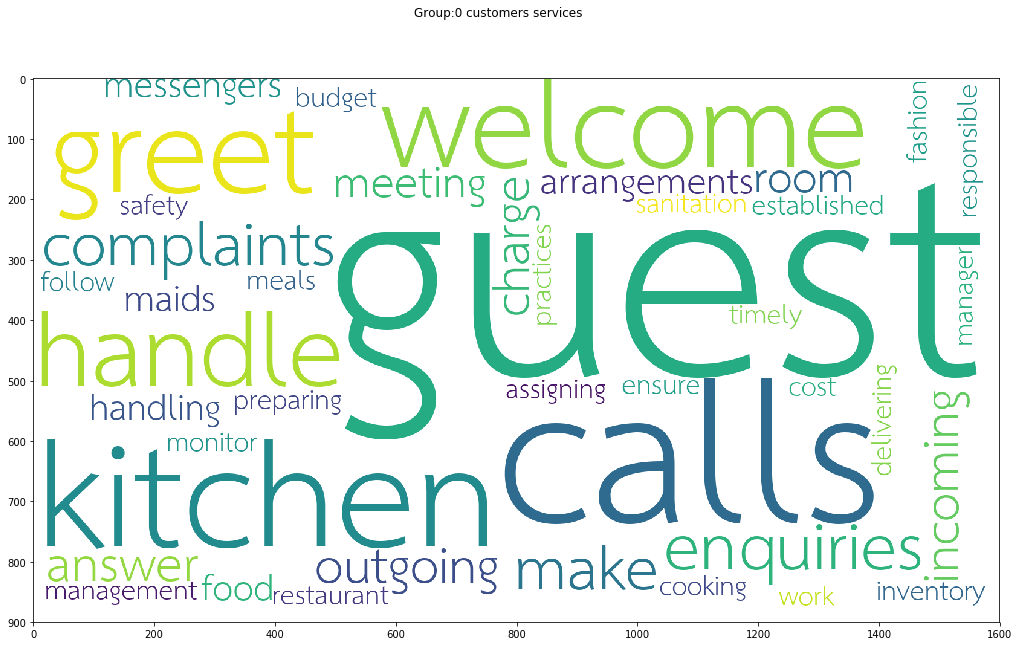

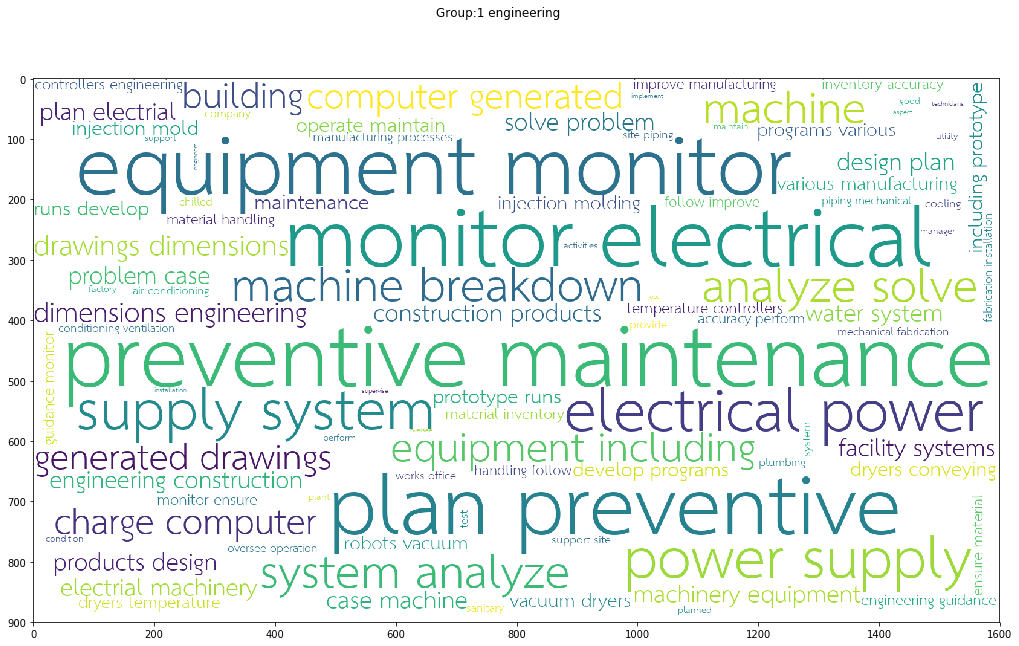

In [33]:
wc(adecco_calc,[0,1],dict_jd_dec_8)

In [59]:
adecco_stats =stats_k(adecco_calc.k_jd, dict_jd_dec_8)
adecco_stats.head()

group_num              group_name  val_count
0  0          customers services      3        
1  1          engineering             28       
2  2          sales                   59       
3  3          production              294      
4  4          accounting and finance  41

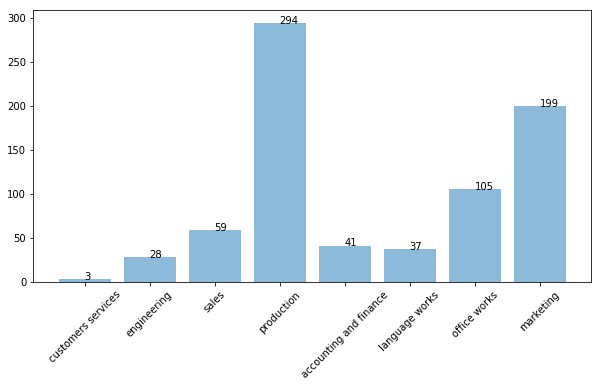

In [60]:
objects = adecco_stats.group_name
y_pos = np.arange(len(objects))
performance = adecco_stats.val_count


plt.figure(figsize=[10,5])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)

for a,b in zip(y_pos, performance):
    plt.text(a, b, str(b))

plt.show()

In [63]:
topwords(adecco_calc, range(8))

Group 0: calls kitchen greet welcome guests handle guest enquiries complaints make
Group 1: system equipment plan maintenance machines engineering monitor electrical material preventive
Group 2: sales customers customer products provide clients service support team handle
Group 3: quality process ensure design manage control production products perform data
Group 4: accounting financial prepare tax handle responsible reports transactions payment manage
Group 5: design develop web copy website art using production knowledge content
Group 6: departments related support provide administrative handle functions management tasks oversee
Group 7: marketing sales business company develop product support management responsible team


In [77]:
adecco_calc.iloc[0,:].T

k_jd                      4                                                                                                                                                                                                                                                               
Unnamed: 0                0                                                                                                                                                                                                                                                               
index                     1                                                                                                                                                                                                                                                               
Unnamed: 0.1              1                                                                                                                            

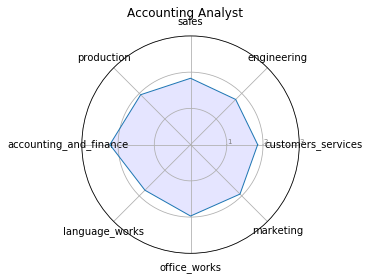

In [88]:
from math import pi

#https://python-graph-gallery.com/390-basic-radar-chart/
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'customers_services': [1-(0.128904)**0.1, 0, 0, 0],
'engineering': [1-(0.143886)**0.1, 0, 0, 0],
'sales': [1-(0.132249)**0.1, 0, 0, 0],
'production': [1-(0.114645)**0.1, 0, 0, 0],
'accounting_and_finance': [1-(0.0805651 )**0.1 , 0, 0, 0],
"language_works": [1-(0.140878)**0.1,0,0,0],
"office_works": [1-(0.111435)**0.1,0,0,0] ,
"marketing":[1-(0.117172)**0.1,0,0,0]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
plt.suptitle("Accounting Analyst")

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=10)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.3], ["1","2","3"], color="grey", size=7)
plt.ylim(0,.3)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)




In [89]:
adecco_calc.iloc[54,:].T

k_jd                      3                                                                      
Unnamed: 0                54                                                                     
index                     124                                                                    
Unnamed: 0.1              124                                                                    
position                  System Engineer                                                        
jd_en                     Analyze, design and provide configuration of server systems to clients.
url                       https://adecco.co.th/salary-guide/2019/00004/219#job-des               
variable                  newgrad                                                                
wage                      21500                                                                  
newgrad                   1                                                                      
senior              

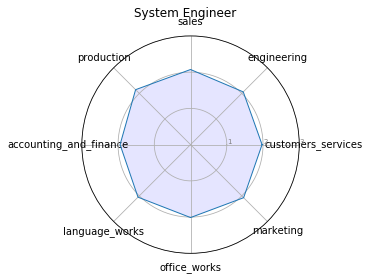

In [33]:
from math import pi

#https://python-graph-gallery.com/390-basic-radar-chart/
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'customers_services': [1-(0.136241)**0.01, 0, 0, 0],
'engineering': [1-(0.125052)**0.01, 0, 0, 0],
'sales': [1-(0.123129 )**0.01, 0, 0, 0],
'production': [1-(0.11446)**0.01, 0, 0, 0],
'accounting_and_finance': [1-(0.140312 )**0.01 , 0, 0, 0],
"language_works": [1-(0.125966)**0.01,0,0,0],
"office_works": [1-(0.130962)**0.01,0,0,0] ,
"marketing":[1-(0.123311)**0.01,0,0,0]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
plt.suptitle("System Engineer")

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=10)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.01,0.02,0.03], ["1","2","3"], color="grey", size=7)
plt.ylim(0,.03)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)



